In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

Imports

In [2]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset

Loading contents from file...


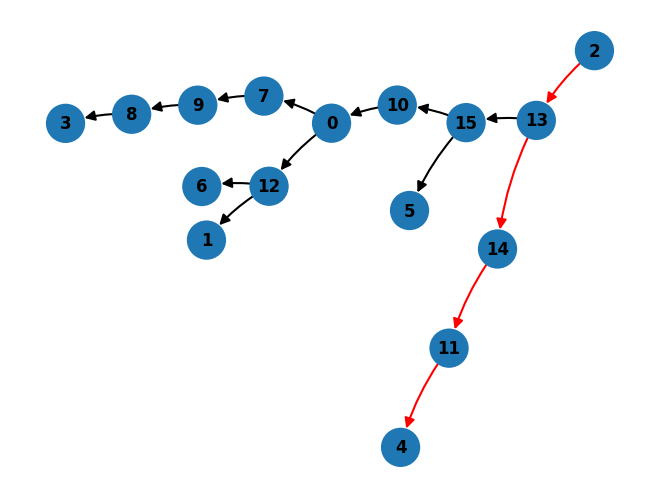

In [3]:
n_examples = 300_000
n_states = 16
dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

Model

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

### Dataset

In [5]:
act_names = ["blocks.1.ln2.hook_normalized", "blocks.2.ln2.hook_normalized", "blocks.3.ln2.hook_normalized", "blocks.4.ln2.hook_normalized", "blocks.5.ln2.hook_normalized", "ln_final.hook_normalized"]
model.reset_hooks()

if not os.path.exists("activations_small.pt"):
    print("Generating activations...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=1000,
        path_length=7,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=500,
        path_length=7,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , "activations_small.pt")
else:
    acts, graphs, test_acts, test_graphs = torch.load("activations_small.pt")

SAE

In [6]:
sae = SparseCoder(num_codes=4*model.cfg.d_model, verbose=True)

In [7]:
# load
checkpoint = torch.load('sae_block_4_hook_.pt')
sae.construct_model(128)
sae.model.load_state_dict(checkpoint)
sae.model.to('cuda')

this is the Anthropic SAE


SparseAutoencoder()

SAE Evaluations

In [8]:
# Evaluation: Use reconstructed activations in the model and see how bad it gets

from functools import partial

def eval_model(model, dataset, test_graph):
    model.eval()
    
    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 2
    curr_idx = start_idx

    flag = False
    while not flag and curr_idx < dataset.max_seq_length - 1:
        # Convert to pytorch
        input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
        input_tokens[curr_idx:] = 0
        input_tokens = input_tokens.unsqueeze(0)[:, :-1]
        # Run model
        with torch.no_grad():
            outputs = model(input_tokens).argmax(-1)
            pred = outputs[0, curr_idx-1]
            test_graph_tokens[curr_idx] = pred.item()
            if pred.item() == dataset.pad_token:  # Check if we reached the goal
                flag = True
        curr_idx += 1

    final_path = dataset.untokenize(test_graph_tokens[:curr_idx])
    
    first_move_correct = dataset.tokenize(test_graph)[48] == dataset.tokenize(final_path)[48]
    return final_path, test_graph == final_path, first_move_correct


def add_sae_hook(layer):

    # Add low-rank hook
    def sae_hook(
            acts,
            hook):
        b, c, d = acts.shape  # e.g. [1, 65, 128]
        f, r = sae.model(acts)
        acts[:, 47, :] = r[:, 47, :]
        return acts

    temp_hook_fn = partial(sae_hook)
    model.blocks[layer].ln2.hook_normalized.add_hook(temp_hook_fn)


model.reset_hooks()
add_sae_hook(5)

start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  total_first_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct, first_correct = eval_model(model, dataset, graph)
      if first_correct:
        total_first_correct += 1      

  print(f"With Hook {order}: {100* total_first_correct / num_samples:.4f}%")

model.reset_hooks()
for order in ["forward", "backward", "random"]:
  total_correct = 0
  total_first_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct, first_correct = eval_model(model, dataset, graph)
      if first_correct:
        total_first_correct += 1      

  print(f"Without Hook {order}: {100* total_first_correct / num_samples:.4f}%")


With Hook forward: 100.0000%
With Hook backward: 99.6000%
With Hook random: 99.9000%
Without Hook forward: 100.0000%
Without Hook backward: 99.4000%
Without Hook random: 99.9000%


Visualizations

In [9]:
def get_learned_dict(sae):
    norms = torch.norm(sae.model.W_e, 2, dim=-1)
    return sae.model.W_e / torch.clamp(norms, 1e-8)[:, None]

dict = get_learned_dict(sae)

In [10]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
from itertools import islice
max_seq_length = dataset.max_seq_length - 1
device = 'cuda'
sae.model.to(device)
def get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32,datapoints=32):
    num_features, d_model = autoencoder.model.W_e.shape
    
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad():
        dl = DataLoader(dataset, batch_size=batch_size)
        for i, batch in enumerate(tqdm(islice(dl,int(datapoints/batch_size)))):
            batch = batch[0][:, :-1].to(device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            batched_dictionary_activations, _ = autoencoder.model(batched_neuron_activations.cuda())
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list
dataset_small=dataset[0:32]
print("Getting dictionary activations")
#datapoints = len(dataset)
datapoints=32*1000
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, 'blocks.5.ln2.hook_normalized', sae, batch_size=32,datapoints=datapoints)

Getting dictionary activations


1000it [00:17, 57.64it/s]


In [11]:
# look at feature density / look at features which activate a lot / highly affect logits

In [1]:

from collections import defaultdict

def get_feature_indices(feature_index, dictionary_activations, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    return found_indices

def get_feature_datapoints(found_indices, best_feature_activations, max_seq_length, dataset):
    num_datapoints = datapoints
    print(num_datapoints)
    datapoint_indices =[np.unravel_index(i, (num_datapoints, max_seq_length)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, max_seq_length).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        if s_ind == 47:
            md = int(md)
            s_ind = int(s_ind)
            full_tok = torch.tensor(dataset[md][0])
            full_text.append(dataset.untokenize(full_tok))
            tok = dataset[md][0][:s_ind+1]
            full_activations.append(all_activations[md])
            partial_activations.append(all_activations[md][:s_ind+1])
            text = dataset.untokenize(tok)
            text_list.append(text)
            token_list.append(tok)
            full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations


import os

# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10000

# features = [1,2,3,4,5,6,7,8,9,10]
feature = 4
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
text_list

NameError: name 'dictionary_activations' is not defined

14>2,4>5,9>15,7>13,11>14,3>0,13>8,15>4,1>7,8>3,5>10,9>1,10>12,2>9,6>11|12:6


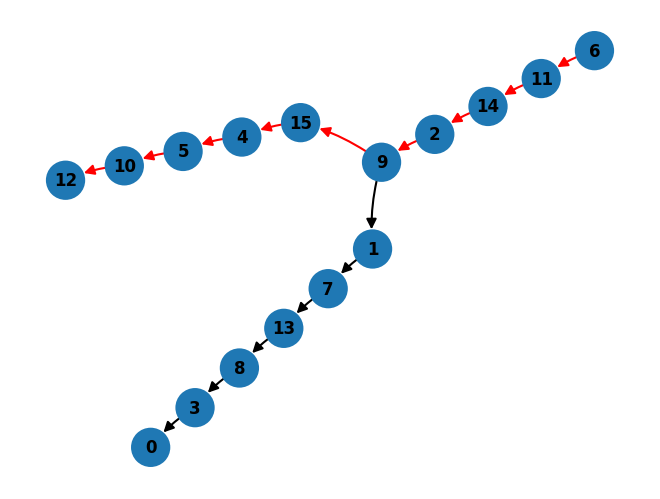

4>2,15>10,4>14,8>1,10>13,11>0,15>8,3>9,0>7,6>4,1>5,10>11,7>12,6>3,8>6|12:15


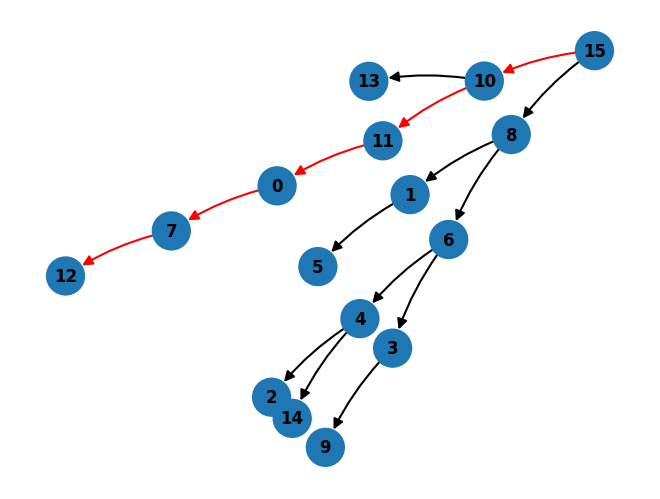

1>9,8>7,2>14,2>6,15>11,15>10,5>4,3>8,7>5,2>3,3>1,8>0,11>2,0>13,3>12|12:15


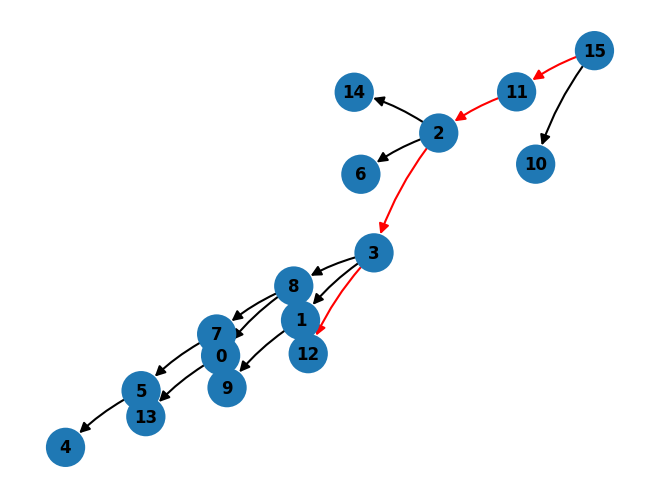

11>3,5>9,0>13,9>10,3>1,2>6,5>8,15>5,2>15,11>2,4>11,10>14,7>0,10>12,1>7|12:4


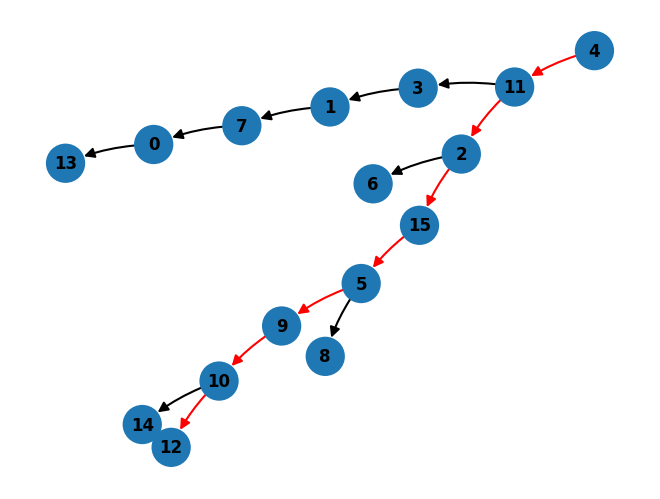

7>5,5>14,8>4,15>1,6>7,7>12,13>2,2>0,8>15,6>10,6>13,15>6,2>3,10>11,5>9|12:8


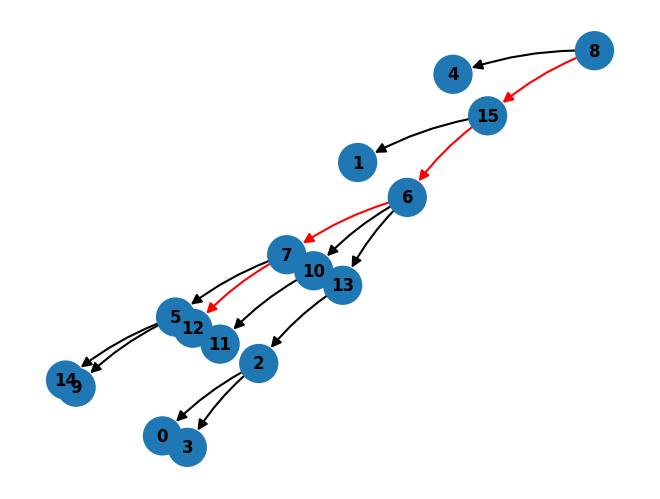

0>5,11>3,7>10,13>1,11>8,2>9,15>11,3>4,4>13,3>12,8>7,11>14,14>0,4>2,14>6|12:15


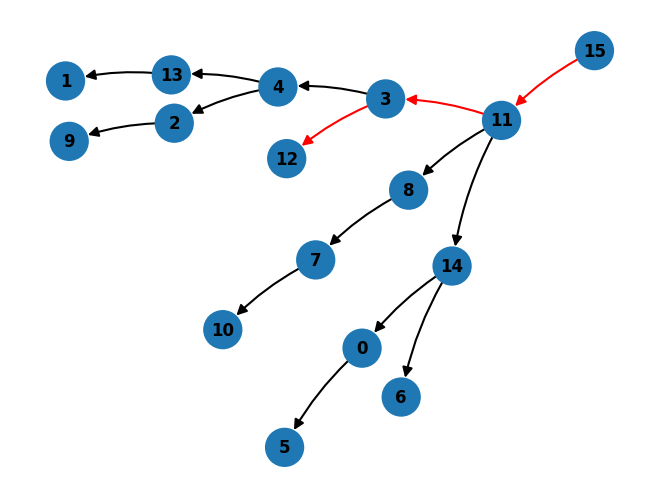

7>2,5>3,11>7,0>9,9>10,13>6,7>0,6>14,3>12,15>1,15>13,15>11,9>5,3>8,15>4|12:15


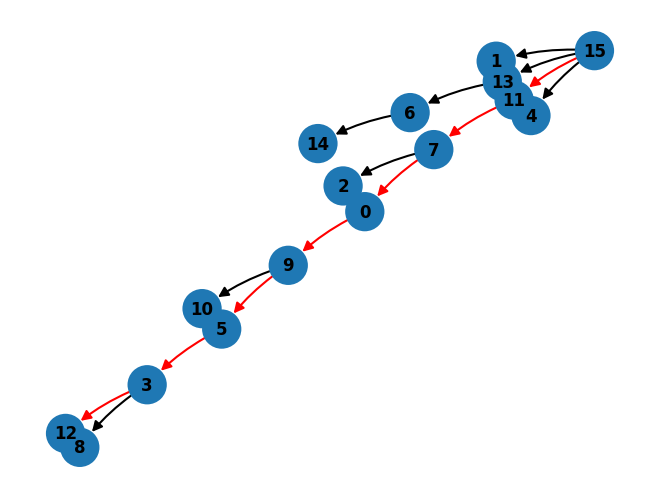

1>2,9>10,15>1,6>5,0>15,2>13,10>0,5>9,13>7,4>3,13>14,6>11,14>4,1>8,3>12|12:6


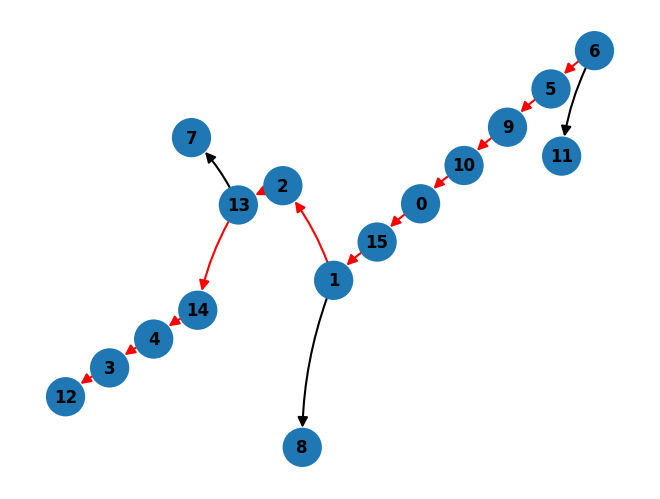

8>10,15>13,13>5,13>1,3>6,5>9,7>15,6>4,6>0,9>12,15>2,1>14,10>3,1>11,0>7|12:8


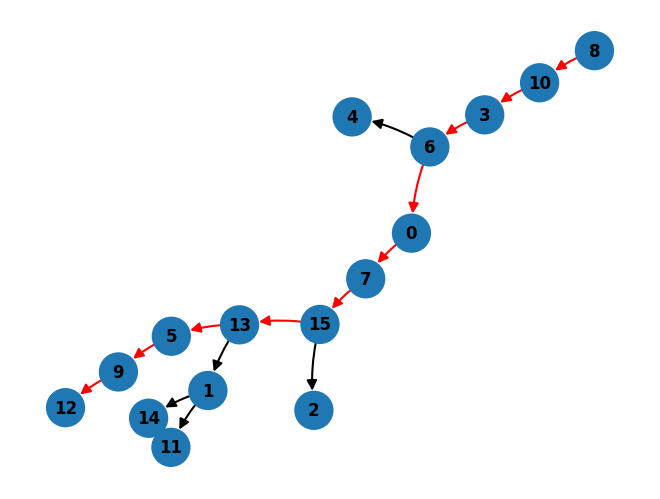

13>2,15>14,3>12,5>3,0>10,15>7,7>8,15>11,15>9,6>0,14>6,10>4,4>5,8>13,14>1|12:15


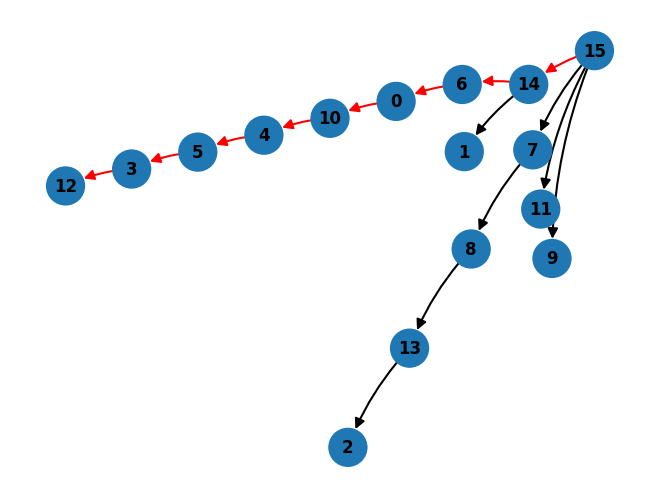

In [13]:
n = 10
for subset, full in zip(text_list[:n], full_text[:n]):
    print(subset)
    parse_example(full)
    plt.show()

8>15,3>0,3>14,11>10,7>8,8>12,10>6,2>7,4>3,1>13,2>5,11>1,5>4,2>9,6>2|13:11


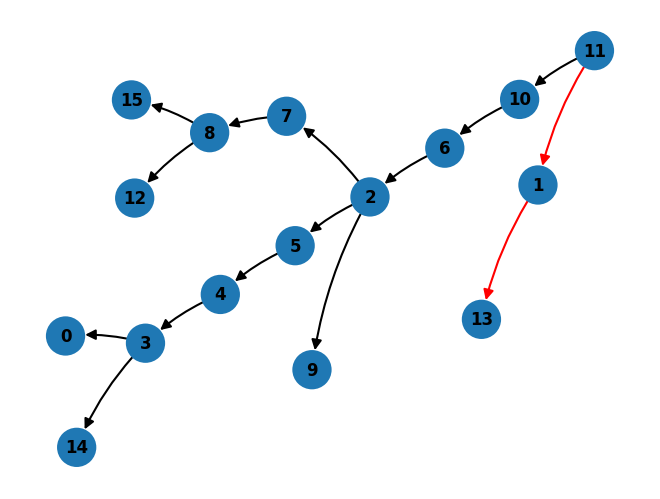

2>7,1>6,4>13,6>5,2>12,13>9,13>11,8>14,5>8,12>4,14>15,14>3,4>0,4>1,13>10|7:2


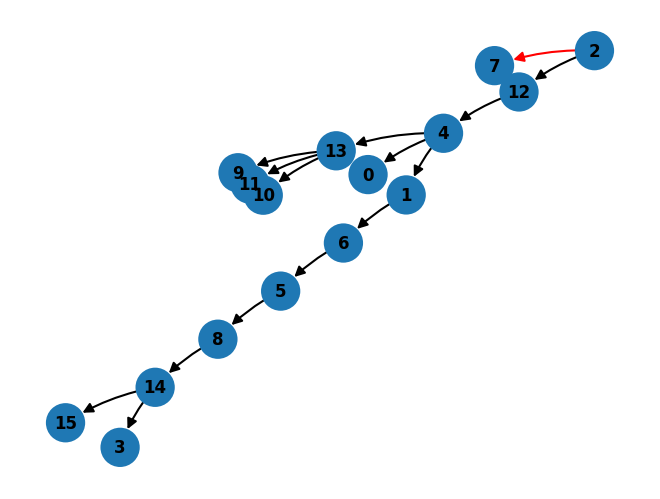

13>4,12>1,7>12,14>5,4>7,12>0,14>13,7>6,6>10,0>8,10>3,13>9,2>14,1>15,12>11|8:2


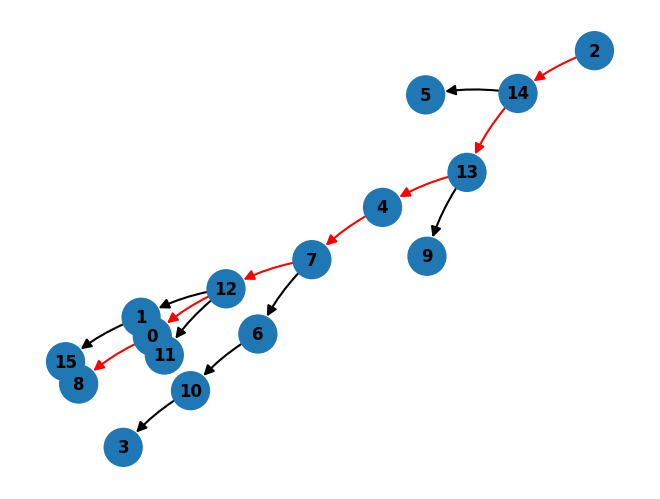

3>5,0>15,9>14,0>11,4>10,2>4,13>2,5>0,1>12,8>9,2>8,5>13,12>7,3>1,5>6|10:3


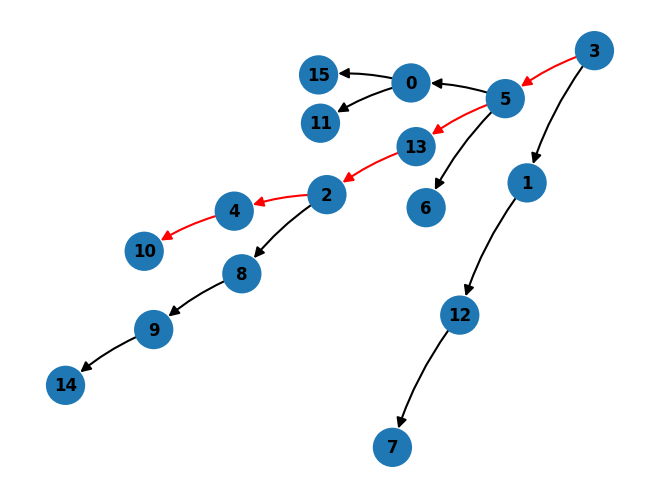

4>5,2>14,5>13,12>1,4>10,4>15,5>12,10>8,5>6,7>9,10>2,11>0,6>11,11>7,6>3|0:4


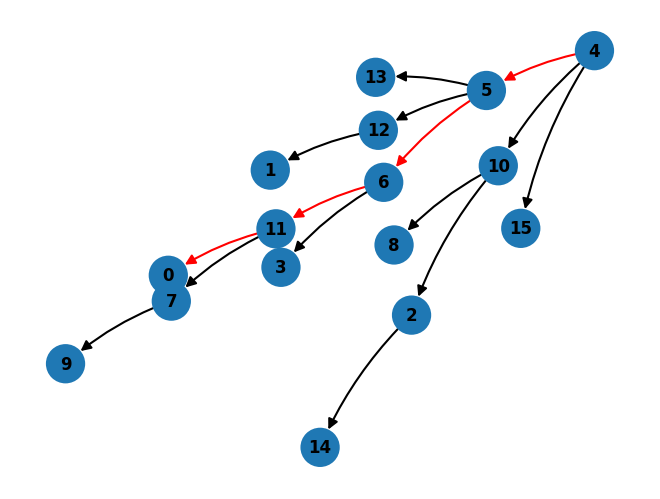

7>10,0>14,8>6,8>2,3>7,0>9,1>8,1>13,0>1,13>11,4>15,6>4,8>12,6>5,9>3|15:0


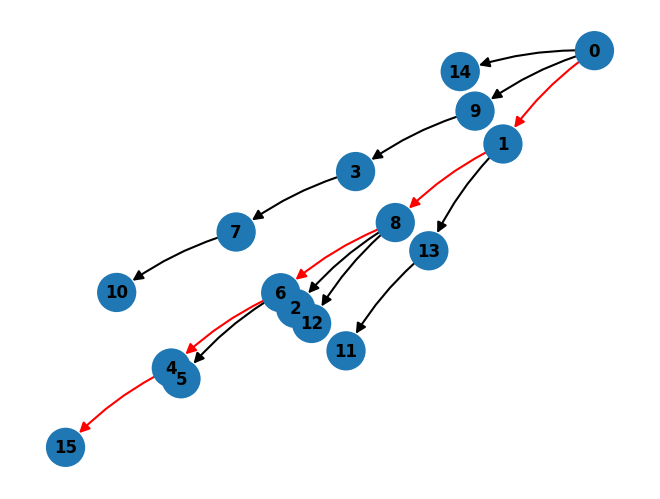

11>12,14>11,0>9,5>8,4>14,4>5,13>7,0>15,8>2,9>3,12>0,3>1,7>4,12>6,0>10|2:13


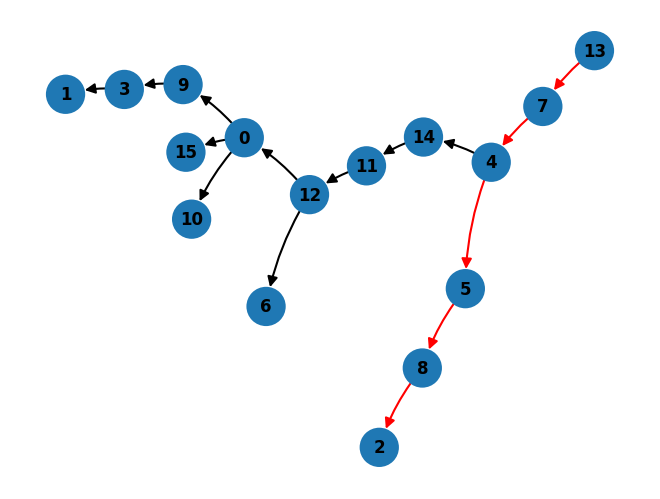

8>2,15>0,6>7,5>1,15>10,12>11,6>5,8>9,8>15,15>14,3>12,4>13,2>6,4>8,6>3|13:4


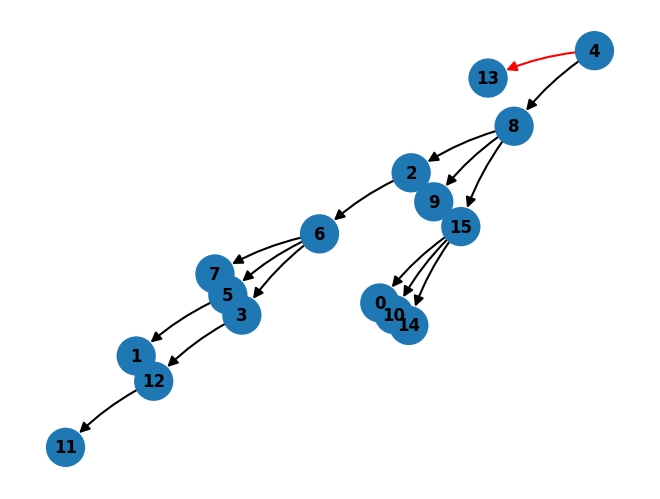

9>15,7>1,2>7,15>0,11>8,8>5,9>3,14>11,9>4,6>13,0>12,7>14,4>2,4>6,2>10|13:9


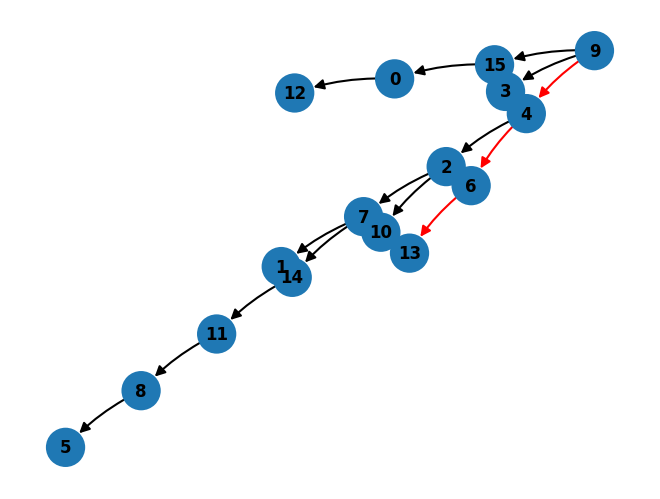

12>10,0>13,9>11,14>5,2>4,5>3,12>0,2>7,10>8,2>6,1>14,10>9,3>15,3>12,5>2|4:1


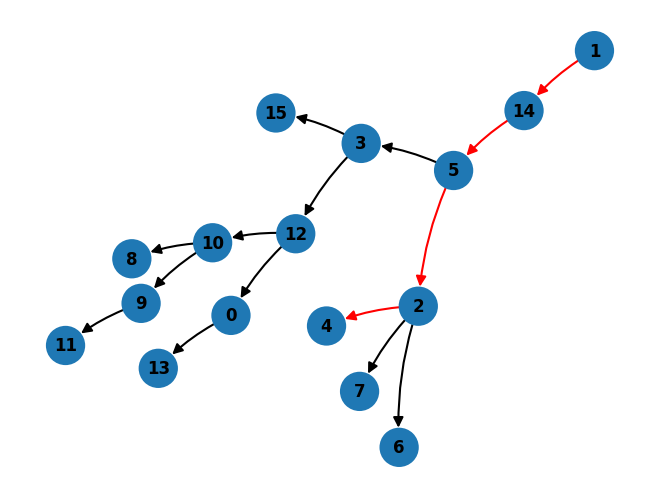

In [14]:
#lowest activated examples
n = 10
for subset, full in zip(text_list[-n:], full_text[-n:]):
    print(subset)
    parse_example(full)
    plt.show()

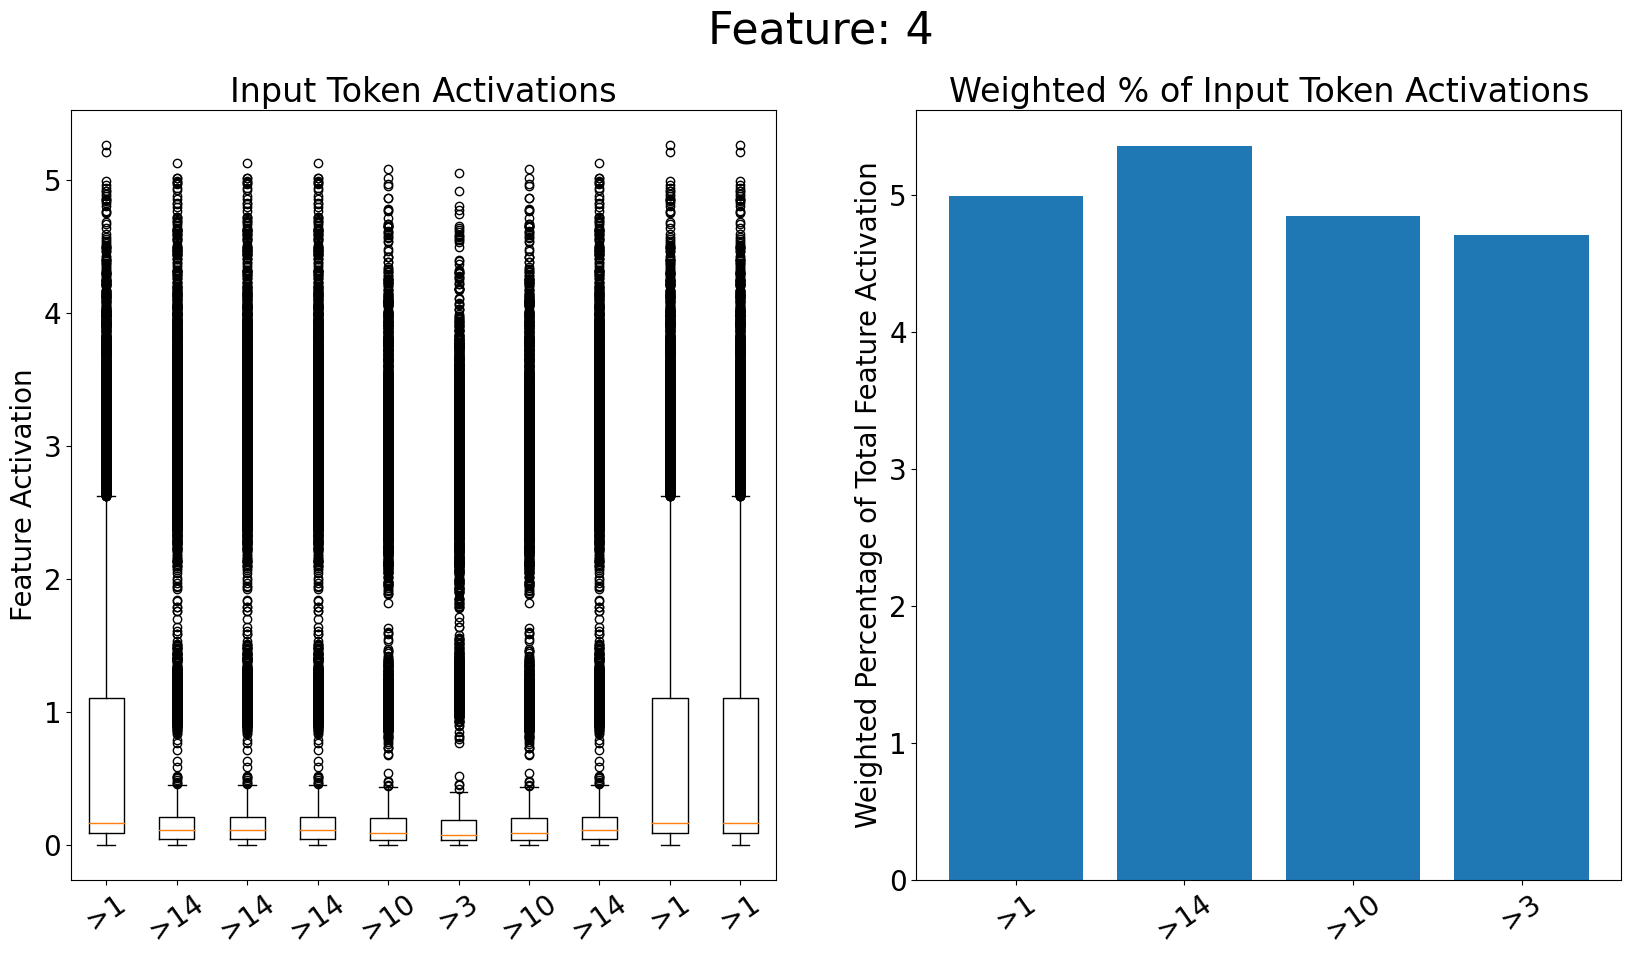

In [15]:
def get_token_statistics(feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location="", num_unique_tokens=10, setting="input", negative_threshold=-0.01):
    if(setting=="input"):
        nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
    else:
        nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
    nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

    # Unravel the indices to get the token IDs
    datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]
    all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

    # Find the max value for each unique token
    token_value_dict = defaultdict(int)
    for token, value in zip(all_tokens, nonzero_values):
        token_value_dict[token] = max(token_value_dict[token], value)
    # if(setting=="input"):
    sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
    # else:
    #     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
    # Take the top 10 (or fewer if there aren't 10)
    max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
    total_sums = nonzero_values.abs().sum()
    max_token_sums = []
    token_activations = []
    assert len(max_tokens) > 0, "No tokens found for this feature"
    for max_token in max_tokens:
        # Find ind of max token
        max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
        # Grab the values for those indices
        max_token_values = nonzero_values[max_token_indices]
        max_token_sum = max_token_values.abs().sum()
        max_token_sums.append(max_token_sum)
        token_activations.append(max_token_values)

    if(setting=="input"):
        title_text = "Input Token Activations"
        save_name = "input"
        y_label = "Feature Activation"
    else:
        title_text = "Output Logit-Difference"
        save_name = "logit_diff"
        y_label = "Logit Difference"

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Add a supreme title for the entire figure
    if(setting=="input"):
        fig.suptitle(f"Feature: {feature}", fontsize=32)

    # Boxplot on the left
    ax = axs[0]
    ax.set_title(f'{title_text}')
    max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    ax.set_ylabel(y_label)
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.boxplot(token_activations[::-1], labels=max_text[::-1])

    # Bar graph on the right
    ax = axs[1]
    ax.set_title(f'Weighted % of {title_text}')
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
    ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

    # Save the figure
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')

    return

get_token_statistics(feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)

In [16]:
feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location, num_unique_tokens, setting, negative_threshold = feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_path, 10, "input", -0.01

if(setting=="input"):
    nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
else:
    nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

# Unravel the indices to get the token IDs
datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]

In [17]:
len([md for md in nonzero_values])

377615

In [18]:
all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

In [19]:
all_graphs = [dataset[int(md)][0] for md, s_ind in datapoint_indices]

In [20]:
len(all_graphs)

377615

In [21]:
# Find the max value for each unique token
token_value_dict = defaultdict(int)
for token, value in zip(all_tokens, nonzero_values):
    token_value_dict[token] = max(token_value_dict[token], value)
# if(setting=="input"):
sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
# else:
#     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
# Take the top 10 (or fewer if there aren't 10)
max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
total_sums = nonzero_values.abs().sum()
max_token_sums = []
token_activations = []
assert len(max_tokens) > 0, "No tokens found for this feature"
for max_token in max_tokens:
    # Find ind of max token
    max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
    # Grab the values for those indices
    max_token_values = nonzero_values[max_token_indices]
    max_token_sum = max_token_values.abs().sum()
    max_token_sums.append(max_token_sum)
    token_activations.append(max_token_values)

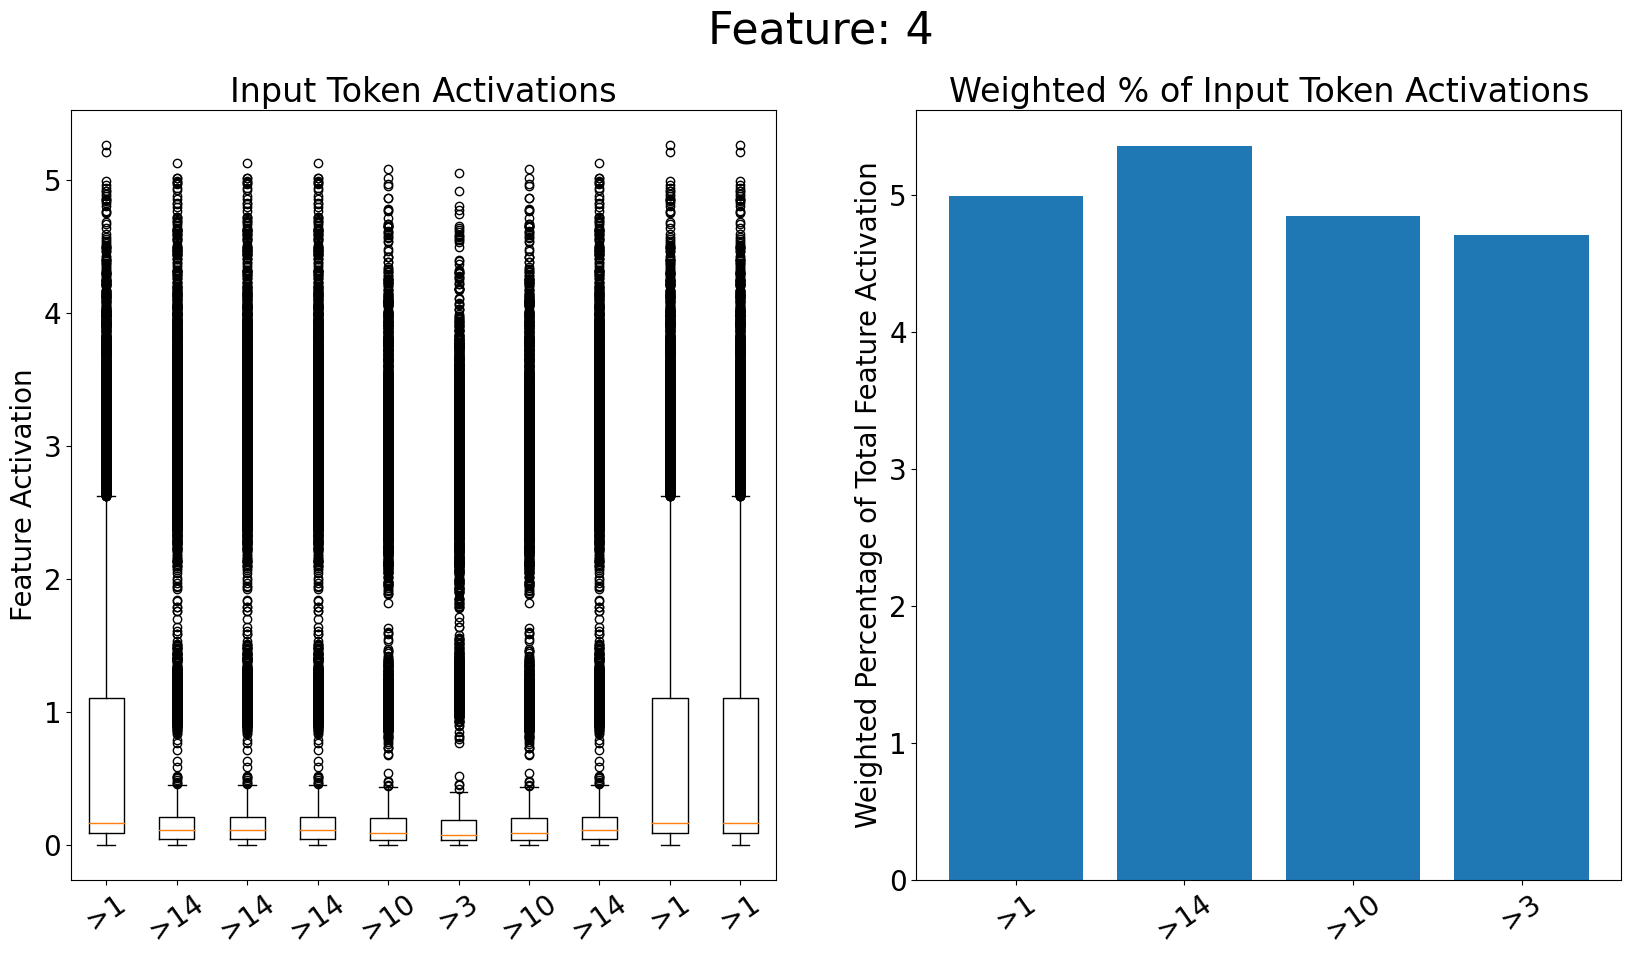

In [22]:
if(setting=="input"):
    title_text = "Input Token Activations"
    save_name = "input"
    y_label = "Feature Activation"
else:
    title_text = "Output Logit-Difference"
    save_name = "logit_diff"
    y_label = "Logit Difference"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Add a supreme title for the entire figure
if(setting=="input"):
    fig.suptitle(f"Feature: {feature}", fontsize=32)

# Boxplot on the left
ax = axs[0]
ax.set_title(f'{title_text}')
max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
ax.set_ylabel(y_label)
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.boxplot(token_activations[::-1], labels=max_text[::-1])

# Bar graph on the right
ax = axs[1]
ax.set_title(f'Weighted % of {title_text}')
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

# Save the figure
plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')